In [48]:
pip install tensorflow


In [49]:
import os
import pathlib
import shutil
import random

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt


In [50]:
# Detailed shell scripts for setting up datasets
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
archive_file = "aclImdb_v1.tar.gz"
unsup_folder = "aclImdb/train/unsup"

!curl {dataset_url} -O
!tar -xf {archive_file}
!rm -r {unsup_folder}



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  18.8M      0  0:00:04  0:00:04 --:--:-- 18.8M


In [51]:
import os

def display_imdb_summary(dataset_path="aclImdb", sample_count=5):
    for data_split in ["train", "test"]:
        print(f"\nSummary of '{data_split}' split:")
        for label in ["pos", "neg"]:
            print(f"  Sentiment: {label}")
            dir_path = os.path.join(dataset_path, data_split, label)
            sample_files = os.listdir(dir_path)[:sample_count]
            for index, sample_name in enumerate(sample_files):
                sample_path = os.path.join(dir_path, sample_name)
                with open(sample_path, "r", encoding="utf-8") as file:
                    sample_lines = file.readlines()
                print(f"\n  File {index + 1}: {sample_name}")
                print(f"    Lines in file: {len(sample_lines)}")
                print(f"    First 5 lines (or fewer):")
                print("    " + "\n    ".join(sample_lines[:5]).strip())


In [52]:
display_imdb_summary()



Summary of 'train' split:
  Sentiment: pos

  File 1: 7880_8.txt
    Lines in file: 1
    First 5 lines (or fewer):
    The plot of this enjoyable MGM musical is contrived and only occasionally amusing, dealing with espionage and romance but the focus of the film is properly pointed upon the tuneful interludes showcasing the enormously talented and athletic tap dancing Eleanor Powell, abetted by Tommy Dorsey and his orchestra, featuring Ziggy Elman, Buddy Rich and Frank Sinatra. Red Skelton shares top billing with Powell, and he and sidekick Bert Lahr are given most of the comedic minutes, although Skelton is more effective when he, if it can be believed, performs as Powell's love interest, with Virginia O'Brien actually providing most of the film's humor as the dancer's companion. The technical brilliance of Powell is evidenced during one incredible scene within which Buddy Rich contributes his drumming skills, and which must be viewed several times in order to permit one's breathing

In [53]:
# Get the directories ready for the split validation
batch_size = 32
base_path = pathlib.Path("aclImdb")
validation_path = base_path / "val"
training_path = base_path / "train"

for label in ("neg", "pos"):
    os.makedirs(validation_path / label, exist_ok=True)
    all_files = os.listdir(training_path / label)
    random.Random(1337).shuffle(all_files)
    val_count = int(0.2 * len(all_files))
    validation_files = all_files[-val_count:]

    for file in validation_files:
        source_path = training_path / label / file
        target_path = validation_path / label / file
        if not os.path.exists(target_path):
            shutil.move(source_path, target_path)


In [54]:
# Loading the datasets from the directories
training_dataset = keras.utils.text_dataset_from_directory(
    base_path / "train", batch_size=batch_size
)

validation_dataset = keras.utils.text_dataset_from_directory(
    base_path / "val", batch_size=batch_size
)

test_dataset = keras.utils.text_dataset_from_directory(
    base_path / "test", batch_size=batch_size
)

# Creating a dataset containing only text (without any labels)
text_only_training = training_dataset.map(lambda x, y: x)


Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [55]:
# Setting the vectorization parameters
sequence_length = 150
vocab_size = 10000

text_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Using the training text to adjust the vectorizer
text_vectorizer.adapt(text_only_training)


In [56]:
# Use the text vectorizer to tokenize datasets
tokenized_train = training_dataset.map(
    lambda x, y: (text_vectorizer(x), y),
    num_parallel_calls=4).take(100)  # Restricting the training samples to 100

tokenized_val = validation_dataset.map(
    lambda x, y: (text_vectorizer(x), y),
    num_parallel_calls=4).take(10000)  # Restricting the validation samples to 10,000

tokenized_test = test_dataset.map(
    lambda x, y: (text_vectorizer(x), y),
    num_parallel_calls=4)


In [57]:
# Establish a simple text classification model with LSTM and embedding layers
input_layer = keras.Input(shape=(None,), dtype="int64")
embedding_output = layers.Embedding(input_dim=vocab_size, output_dim=128)(input_layer)
lstm_output = layers.Bidirectional(layers.LSTM(32))(embedding_output)
dropout_output = layers.Dropout(rate=0.3)(lstm_output)
final_output = layers.Dense(1, activation="sigmoid")(dropout_output)

sentiment_model = keras.Model(inputs=input_layer, outputs=final_output)

sentiment_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"])

sentiment_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Establish a checkpoint to preserve the model's peak performance
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="embedding_model.keras",save_best_only=True)
]


In [59]:
# Create the model and save the training data for further examination
history_embedded = sentiment_model.fit(
    tokenized_train,
    validation_data=tokenized_val,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.5221 - loss: 0.6926 - val_accuracy: 0.5602 - val_loss: 0.7068
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6584 - loss: 0.6201 - val_accuracy: 0.7444 - val_loss: 0.5469
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7822 - loss: 0.4927 - val_accuracy: 0.8024 - val_loss: 0.4571
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.8497 - loss: 0.3820 - val_accuracy: 0.8214 - val_loss: 0.4142
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.8841 - loss: 0.3054 - val_accuracy: 0.8216 - val_loss: 0.4195
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9095 - loss: 0.2499 - val_accuracy: 0.7982 - val_loss: 0.4481
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9353 - loss: 0.1967 - val_accuracy: 0.8286 - val_loss: 0.4474
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9378 - loss: 0.1772 - val_acc

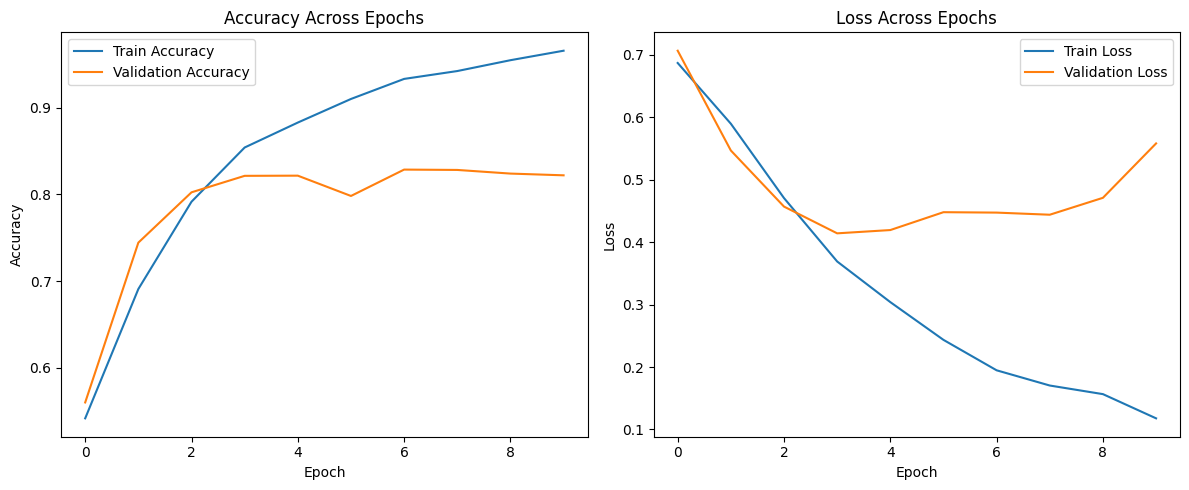

In [60]:
# Retrieve metrics from the model's training process
training_stats = history_embedded.history

# Preparing the canvas for two plots adjacent to one other
plt.figure(figsize=(12, 5))

# Accuracy Plotting for Training and Validation
plt.subplot(1, 2, 1)
plt.plot(training_stats['accuracy'], label='Train Accuracy')
plt.plot(training_stats['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss for Training and Validation
plt.subplot(1, 2, 2)
plt.plot(training_stats['loss'], label='Train Loss')
plt.plot(training_stats['val_loss'], label='Validation Loss')
plt.title('Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Presenting everything clean and neatly
plt.tight_layout()
plt.show()


In [61]:
# Retrieve pre-trained GloVe word vectors from the NLP website at Stanford
!wget http://nlp.stanford.edu/data/glove.6B.zip

# Silently extract the downloaded archive
!unzip -q glove.6B.zip



--2025-04-08 15:23:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 15:23:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 15:23:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

gl

In [62]:
# Use pre-trained GloVe embeddings to set up the matrix
glove_dim = 100
glove_path = "glove.6B.100d.txt"

# The GloVe vectors are loaded into a dictionary
glove_index = {}
with open(glove_path, "r", encoding="utf8") as file:
    for line in file:
        token, vector = line.strip().split(maxsplit=1)
        glove_index[token] = np.fromstring(vector, dtype="f", sep=" ")

# Create an embedding matrix that matches the language of our model
vocab_list = text_vectorizer.get_vocabulary()
vocab_lookup = {word: idx for idx, word in enumerate(vocab_list)}

embedding_matrix = np.zeros((vocab_size, glove_dim))
for word, idx in vocab_lookup.items():
    if idx < vocab_size:
        vector = glove_index.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector


In [63]:
# Use preloaded GloVe weights (frozen) to create an embedding layer
glove_embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=glove_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False, # When training, keep the GloVe weights fixed
    mask_zero=True
)

# Use the pretrained embeddings to define the model structure
input_seq = keras.Input(shape=(None,), dtype="int64")
embedded_seq = glove_embedding(input_seq)
lstm_out = layers.Bidirectional(layers.LSTM(32))(embedded_seq)
dropout_out = layers.Dropout(0.3)(lstm_out)
final_output = layers.Dense(1, activation="sigmoid")(dropout_out)

glove_model = keras.Model(inputs=input_seq, outputs=final_output)


In [64]:
# Use pre-trained GloVe embeddings to construct and assemble the sentiment model
input_layer = keras.Input(shape=(None,), dtype="int64")
embedded_output = glove_embedding(input_layer)
lstm_output = layers.Bidirectional(layers.LSTM(32))(embedded_output)
dropout_layer = layers.Dropout(0.3)(lstm_output)
prediction = layers.Dense(1, activation="sigmoid")(dropout_layer)

pretrained_model = keras.Model(inputs=input_layer, outputs=prediction)

# Using binary classification parameters to compile the model
pretrained_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Printing the model's structure
pretrained_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, None)           │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 64)             │         34,048 │ embedding_3[1][0],     │
│ (Bidirectional)           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             65 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [65]:
# Configure a callback to preserve the optimal GloVe-based model version
glove_callbacks = [
    keras.callbacks.ModelCheckpoint("pretrained_model.keras", save_best_only=True)
]

# Use the tokenized data to train the model
history_glove = pretrained_model.fit(
    tokenized_train,
    validation_data=tokenized_val,
    epochs=10,
    callbacks=glove_callbacks
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.5537 - loss: 0.6958 - val_accuracy: 0.5894 - val_loss: 0.6661
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.6172 - loss: 0.6431 - val_accuracy: 0.6640 - val_loss: 0.6177
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.6790 - loss: 0.5965 - val_accuracy: 0.6456 - val_loss: 0.6397
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.7028 - loss: 0.5684 - val_accuracy: 0.7444 - val_loss: 0.5197
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.7392 - loss: 0.5337 - val_accuracy: 0.7556 - val_loss: 0.5136
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.7439 - loss: 0.5133 - val_accuracy: 0.7712 - val_loss: 0.4817
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.7576 - loss: 0.4942 - val_accuracy: 0.7766 - val_loss: 0.4729
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.7706 - loss: 0

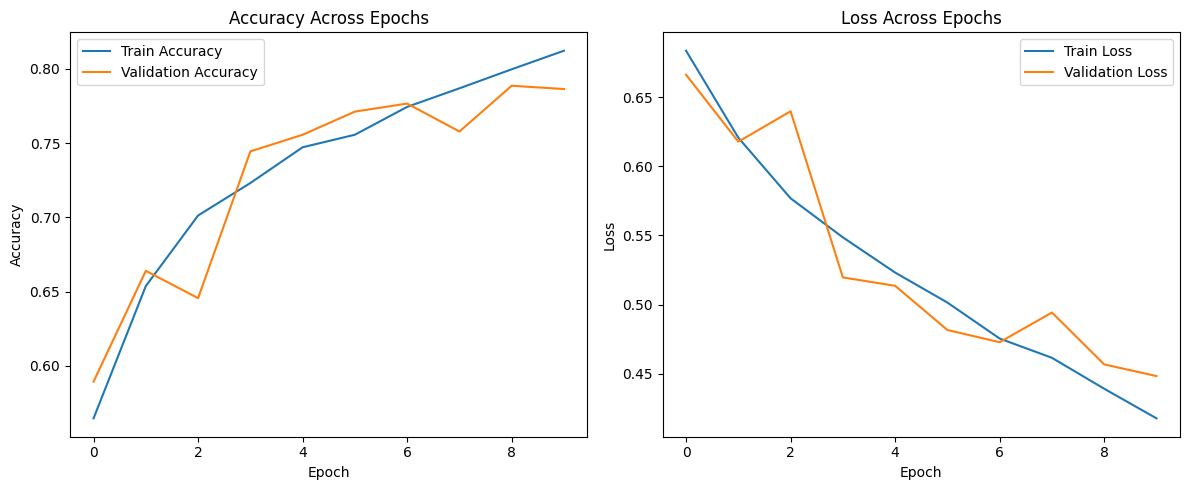

In [66]:
import matplotlib.pyplot as plt

# Extracting the training history from GloVe-based model
metrics = history_glove.history

# Setting up a wide figure with two subplots
plt.figure(figsize=(12, 5))

# Plot accuracy: training vs validation
plt.subplot(1, 2, 1)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss: training vs validation
plt.subplot(1, 2, 2)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Showing both the plots
plt.tight_layout()
plt.show()



### Training with 100 samples ###

Training Custom Embedding Model on 100 samples:
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9605 - loss: 0.1176 - val_accuracy: 0.8344 - val_loss: 0.5587
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9831 - loss: 0.0663 - val_accuracy: 0.7908 - val_loss: 0.5306
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9757 - loss: 0.0799 - val_accuracy: 0.8058 - val_loss: 0.5644
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9797 - loss: 0.0816 - val_accuracy: 0.8138 - val_loss: 0.6496
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9952 - loss: 0.0265 - val_accuracy: 0.8258 - val_loss: 0.6288
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9854 - loss: 0.0489 - val_accuracy: 0.8308 - val_loss: 0.7016
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9977 - loss: 0.0143 - val_accuracy: 0.8126 - val_loss: 0.6292
Epoch 8/10
10

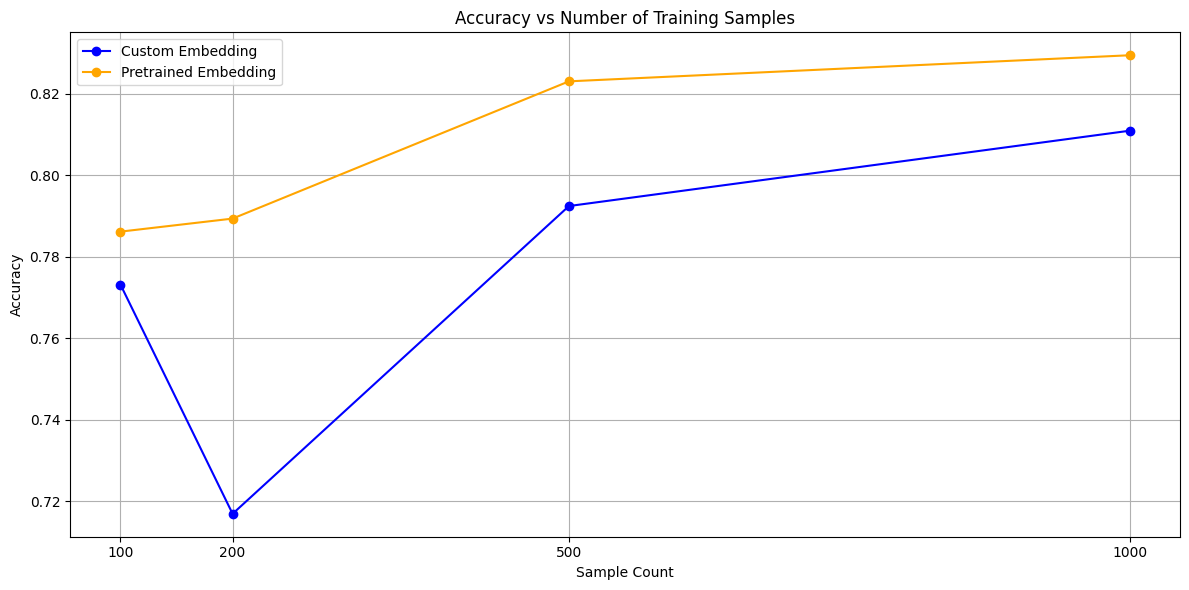

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Defining the sample counts to use for training
sample_counts = [100, 200, 500, 1000]
custom_acc_list = []
glove_acc_list = []

# Setting up the graph
plt.figure(figsize=(12, 6))
plt.title('Accuracy vs Number of Training Samples')
plt.xlabel('Sample Count')
plt.ylabel('Accuracy')
plt.grid(True)

# Loop through various sample sizes
for i, count in enumerate(sample_counts):
    print(f"\n### Training with {count} samples ###\n")

    # Restricting the training set size
    # Replacing 'train_ds' with 'training_dataset' and 'text_vectorization' with 'text_vectorizer'
    limited_train_data = training_dataset.map(
        lambda x, y: (text_vectorizer(x), y)).take(count)

    # Training model with custom embeddings
    print(f"Training Custom Embedding Model on {count} samples:")
    sentiment_model.fit( # Replacing 'embedding_model' with 'sentiment_model'
        limited_train_data,
        validation_data=tokenized_val, # Replacing 'int_val_ds' with 'tokenized_val'
        epochs=10,
        verbose=1
    )
    # Replacing 'embedding_model' with 'sentiment_model' and 'int_test_ds' with 'tokenized_test'
    acc_custom = sentiment_model.evaluate(tokenized_test, verbose=1)[1]
    custom_acc_list.append(acc_custom)
    print(f"Custom Embedding Model Accuracy: {acc_custom:.4f}\n")

    # Training the model with pretrained GloVe embeddings
    print(f"Training Pretrained Embedding Model on {count} samples:")
    pretrained_model.fit(
        limited_train_data,
        validation_data=tokenized_val, # Replacing 'int_val_ds' with 'tokenized_val'
        epochs=10,
        verbose=1
    )
    # Replacing 'int_test_ds' with 'tokenized_test'
    acc_glove = pretrained_model.evaluate(tokenized_test, verbose=1)[1]
    glove_acc_list.append(acc_glove)
    print(f"Pretrained Embedding Model Accuracy: {acc_glove:.4f}\n")

    # Plotting once all sample sizes are doen running
    if i == len(sample_counts) - 1:
        plt.plot(sample_counts, custom_acc_list, marker='o', label='Custom Embedding', color='blue')
        plt.plot(sample_counts, glove_acc_list, marker='o', label='Pretrained Embedding', color='orange')

# Final designing of the chart
plt.title('Accuracy vs Number of Training Samples')
plt.xlabel('Sample Count')
plt.ylabel('Accuracy')
plt.xticks(sample_counts)
plt.grid(True)
plt.legend()

# Displaying the chart
plt.tight_layout()
plt.show()

In [69]:
import pandas as pd

# Save the self-trained embedding model's findings
custom_results = {
    "Data Count": sample_counts,
    "Accuracy (Custom Embedding)": custom_acc_list,
}

# Save the GloVe model's pretrained findings
pretrained_results = {
    "Data Count": sample_counts,
    "Accuracy (Pretrained Embedding)": glove_acc_list,
}

# Combine both sets of results into a single DataFrame
results_table = pd.DataFrame({
    "Data Count": sample_counts,
    "Accuracy (Custom Embedding)": custom_acc_list,
    "Accuracy (Pretrained Embedding)": glove_acc_list
})

# Printing the final comparison table
print("Final Comparison Summary:")
print(results_table)


Final Comparison Summary:
   Data Count  Accuracy (Custom Embedding)  Accuracy (Pretrained Embedding)
0         100                      0.77316                          0.78616
1         200                      0.71692                          0.78936
2         500                      0.79244                          0.82304
3        1000                      0.81092                          0.82944


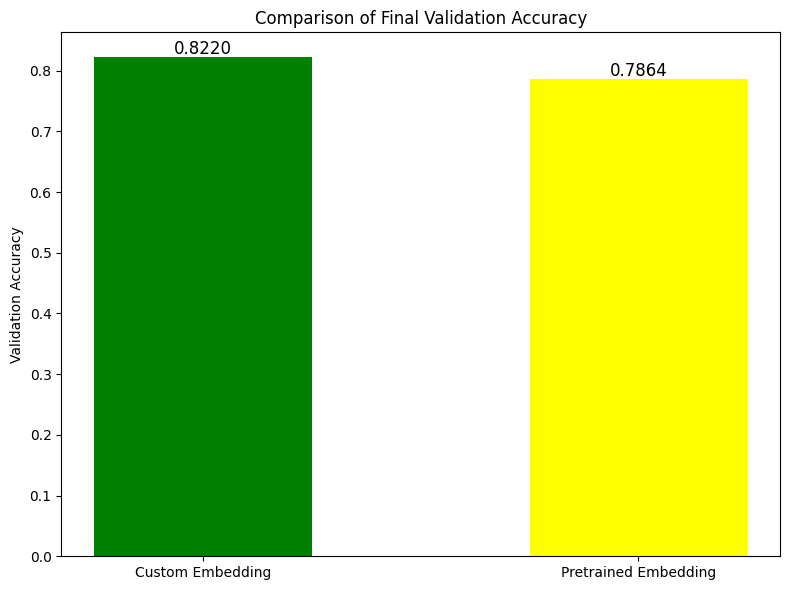

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the model types
model_labels = ['Custom Embedding', 'Pretrained Embedding']
accuracy_scores = [
    history_embedded.history['val_accuracy'][-1],   # Last validation accuracy for custom model
    history_glove.history['val_accuracy'][-1]       # Last validation accuracy for pretrained model
]

# Creating the bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_labels, accuracy_scores, color=['green', 'yellow'], width=0.5)

# Adding axis labels and chart titles
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Final Validation Accuracy')

# Displaying values above each bar
for idx, score in enumerate(accuracy_scores):
    plt.text(idx, score + 0.005, f'{score:.4f}', ha='center', fontsize=12)

# Rendering the final chart
plt.tight_layout()
plt.show()


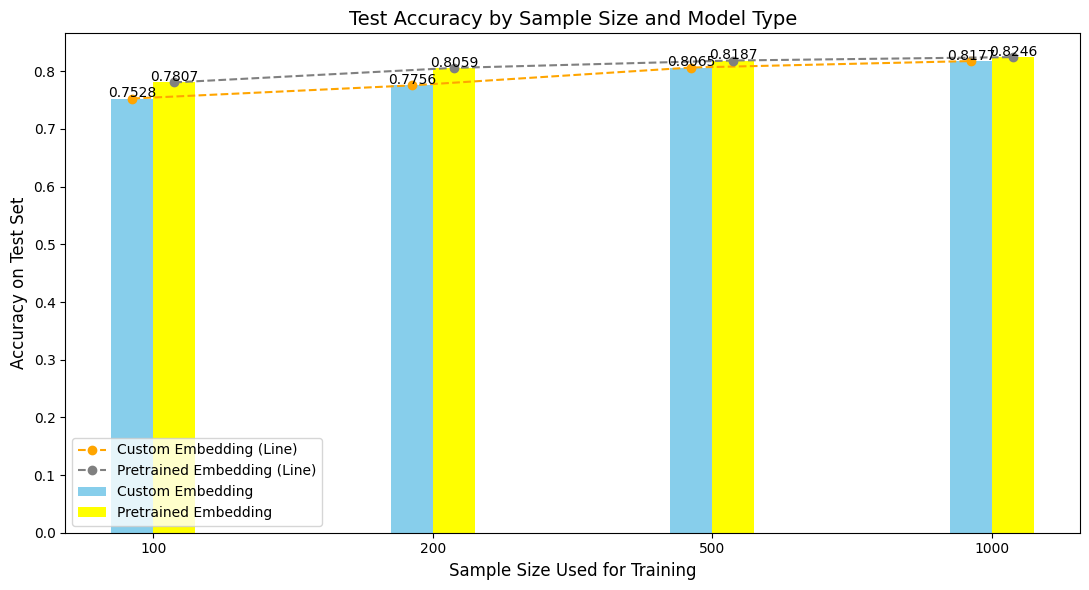

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Training the sample counts
train_sizes = [100, 200, 500, 1000]
custom_model_scores = [0.75280, 0.77556, 0.80652, 0.81772]      # Custom model accuracy
glove_model_scores = [0.78072, 0.80588, 0.81868, 0.82456]       # Pretrained model accuracy

# Bar positioning setting up
bar_width = 0.15
index_positions = np.arange(len(train_sizes))  # Bar centers

# Initializing figure
plt.figure(figsize=(11, 6))

# Plotting the side-by-side bars
plt.bar(index_positions - bar_width / 2, custom_model_scores,
        width=bar_width, label='Custom Embedding', color='skyblue')
plt.bar(index_positions + bar_width / 2, glove_model_scores,
        width=bar_width, label='Pretrained Embedding', color='yellow')

# Adding the line overlays for visual tracking
plt.plot(index_positions - bar_width / 2, custom_model_scores,
         marker='o', color='orange', linestyle='--', label='Custom Embedding (Line)')
plt.plot(index_positions + bar_width / 2, glove_model_scores,
         marker='o', color='grey', linestyle='--', label='Pretrained Embedding (Line)')

# labels and title of the charts
plt.xlabel('Sample Size Used for Training', fontsize=12)
plt.ylabel('Accuracy on Test Set', fontsize=12)
plt.title('Test Accuracy by Sample Size and Model Type', fontsize=14)
plt.xticks(index_positions, train_sizes)
plt.legend()

# Annotation of each bar with its accuracy
for i in range(len(train_sizes)):
    plt.text(index_positions[i] - bar_width / 2, custom_model_scores[i] + 0.002,
             f'{custom_model_scores[i]:.4f}', ha='center', fontsize=10)
    plt.text(index_positions[i] + bar_width / 2, glove_model_scores[i] + 0.002,
             f'{glove_model_scores[i]:.4f}', ha='center', fontsize=10)

# Final display of the charts
plt.tight_layout()
plt.show()
